# Runtime

## Packages

In [1]:
import torch
import gpytorch
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import os
import gpboost as gpb
import requests
import pandas as pd
import time

## Function to generate data

In [ ]:
# Download notebook from GitHub
url = 'https://raw.githubusercontent.com/TimGyger/FSVA/refs/heads/main/Simulation/Simulate_Data.py'

# Download the Python file
response = requests.get(url)

# Save the Python file locally
with open('your_script.py', 'wb') as f:
    f.write(response.content)

print("Python file downloaded successfully!")

# Execute the downloaded Python file using exec()
with open('your_script.py', 'r') as f:
    code = f.read()

exec(code)

## Gaussian Data

In [2]:
#X, y, _ = simulate_gp_response("gaussian",100000, 0.3, 1.0, torch.tensor([(0.25, 0.50,0.75,1.00,1.25)]),1)

In [3]:
# Convert X and y to a DataFrame
# data = pd.DataFrame(X.numpy(), columns=[f"x{i+1}" for i in range(X.shape[1])])
# data['y'] = y.numpy()

# Save to CSV
# data.to_csv("simulated_data_Gaussian.csv", index=False)
# print("Data saved to 'simulated_data_Gaussian.csv'")

In [4]:
# URL of the raw CSV file on GitHub
url = 'https://raw.githubusercontent.com/TimGyger/FSVA/refs/heads/main/Simulation/simulated_data_Gaussian.csv'

# Load the CSV file directly from the URL
df = pd.read_csv(url)

# Select the first 5 columns for X
X = df.iloc[:, :5]  # First 5 columns

# Select the last column for y
y = df.iloc[:, -1]  # Last column

In [5]:
# Convert to numpy:
X_np = X.to_numpy()
y_np = y.to_numpy()

## Experiments

In [7]:
# Different number of inducing points
vector_ind_points = [10, 20, 50, 100, 200, 500]
# Different number of Vecchia neighbors
vector_vecchia = [5, 10, 15, 20, 30, 50]
# Different number of samples
vector_n = [10, 20, 30, 50, 80, 100]
# Zero matrices
matrix_t_vecchia = np.zeros((len(vector_vecchia), 1))
matrix_t_ip = np.zeros((len(vector_ind_points), 1))
matrix_t_n = np.zeros((len(vector_n), 1))
matrix_t_vecchia_v = np.zeros((len(vector_vecchia), 1))
matrix_t_ip_v = np.zeros((len(vector_ind_points), 1))
matrix_t_n_v = np.zeros((len(vector_n), 1))
matrix_t_vecchia_f = np.zeros((len(vector_vecchia), 1))
matrix_t_ip_f = np.zeros((len(vector_ind_points), 1))
matrix_t_n_f = np.zeros((len(vector_n), 1))
# Nested loop to iterate over both vectors
for i, val1 in enumerate(vector_ind_points):
    start_time = time.time()
    # FSVecchia with euclidean-based neighbor search
    model_fsva = gpb.GPModel(gp_coords=X_np, cov_function="gaussian_ard", 
                             likelihood="gaussian",num_neighbors = 30,num_ind_points = val1,ind_points_selection = "kmeans++",
                             matrix_inversion_method = "cholesky", gp_approx="vecchia",seed = 2)
    neg_fsva = model_fsva.neg_log_likelihood(cov_pars = np.array([0.3, 1.0, 0.25, 0.50,0.75,1.00,1.25]), y = y_np)
    # End the timer
    end_time = time.time()
    matrix_t_ip[i, 0] = end_time - start_time

    # Vecchia
    if i == 0:
        start_time = time.time()
        model_v = gpb.GPModel(gp_coords=X_np, cov_function="gaussian_ard", 
                                 likelihood="gaussian",num_neighbors = 30,
                                 matrix_inversion_method = "cholesky", gp_approx="vecchia",seed = 10)
        neg_v = model_v.neg_log_likelihood(cov_pars = np.array([0.3, 1.0, 0.25, 0.50,0.75,1.00,1.25]), y = y_np)
        # End the timer
        end_time = time.time()
        matrix_t_ip_v.fill(end_time - start_time)

    # FITC
    start_time = time.time()
    model_fitc = gpb.GPModel(gp_coords=X_np, cov_function="gaussian_ard", 
                             likelihood="gaussian",num_ind_points = val1,ind_points_selection = "kmeans++",
                             matrix_inversion_method = "cholesky", gp_approx="fitc",seed = 10)
    neg_fitc = model_fitc.neg_log_likelihood(cov_pars = np.array([0.3, 1.0, 0.25, 0.50,0.75,1.00,1.25]), y = y_np)
    # End the timer
    end_time = time.time()
    matrix_t_ip_f[i, 0] = end_time - start_time
    
for i, val1 in enumerate(vector_vecchia):
    start_time = time.time()
    # FSVecchia with euclidean-based neighbor search
    model_fsva = gpb.GPModel(gp_coords=X_np, cov_function="gaussian_ard", 
                             likelihood="gaussian",num_neighbors = val1,num_ind_points = 200,ind_points_selection = "kmeans++",
                             matrix_inversion_method = "cholesky", gp_approx="vecchia",seed = 2)
    neg_fsva = model_fsva.neg_log_likelihood(cov_pars = np.array([0.3, 1.0, 0.25, 0.50,0.75,1.00,1.25]), y = y_np)
    # End the timer
    end_time = time.time()
    matrix_t_vecchia[i, 0] = end_time - start_time

    # FITC
    if i == 0:
        start_time = time.time()
        model_fitc = gpb.GPModel(gp_coords=X_np, cov_function="gaussian_ard", 
                                 likelihood="gaussian",num_ind_points = 200,ind_points_selection = "kmeans++",
                                 matrix_inversion_method = "cholesky", gp_approx="fitc",seed = 10)
        neg_fitc = model_fitc.neg_log_likelihood(cov_pars = np.array([0.3, 1.0, 0.25, 0.50,0.75,1.00,1.25]), y = y_np)
        # End the timer
        end_time = time.time()
        matrix_t_vecchia_f.fill(end_time - start_time)

    # Vecchia
    start_time = time.time()
    model_v = gpb.GPModel(gp_coords=X_np, cov_function="gaussian_ard", 
                          likelihood="gaussian",num_neighbors = val1,
                          matrix_inversion_method = "cholesky", gp_approx="vecchia",seed = 10)
    neg_v = model_v.neg_log_likelihood(cov_pars = np.array([0.3, 1.0, 0.25, 0.50,0.75,1.00,1.25]), y = y_np)
    # End the timer
    end_time = time.time()
    matrix_t_vecchia_v[i, 0] = end_time - start_time

for i, val1 in enumerate(vector_n):
    if val1 < 100:
        np.random.seed(1)
        indices = np.random.choice(X_np.shape[0], size=val1*1000, replace=False)
        # Select the downsampled data
        X_np_sampled = X_np[indices]
        y_np_sampled = y_np[indices]
    else:
        X_np_sampled = X_np
        y_np_sampled = y_np
    
    start_time = time.time()
    # FSVecchia with euclidean-based neighbor search
    model_fsva = gpb.GPModel(gp_coords=X_np_sampled, cov_function="gaussian_ard", 
                             likelihood="gaussian",num_neighbors = 30,num_ind_points = 200,ind_points_selection = "kmeans++",
                             matrix_inversion_method = "cholesky", gp_approx="vecchia",seed = 2)
    neg_fsva = model_fsva.neg_log_likelihood(cov_pars = np.array([0.3, 1.0, 0.25, 0.50,0.75,1.00,1.25]), y = y_np_sampled)
    # End the timer
    end_time = time.time()
    matrix_t_n[i, 0] = end_time - start_time

    # Vecchia
    model_vecchia = gpb.GPModel(gp_coords=X_np_sampled, cov_function="gaussian_ard", 
                             likelihood="gaussian",num_neighbors = 30,
                             matrix_inversion_method = "cholesky", gp_approx="vecchia",seed = 10)
    neg_vecchia = model_vecchia.neg_log_likelihood(cov_pars = np.array([0.3, 1.0, 0.25, 0.50,0.75,1.00,1.25]), y = y_np_sampled)
    # End the timer
    end_time = time.time()
    matrix_t_n_v[i, 0] = end_time - start_time

    # FITC
    model_fitc = gpb.GPModel(gp_coords=X_np_sampled, cov_function="gaussian_ard", 
                             likelihood="gaussian",num_ind_points = 200,ind_points_selection = "kmeans++",
                             matrix_inversion_method = "cholesky", gp_approx="fitc",seed = 10)
    neg_fitc = model_fitc.neg_log_likelihood(cov_pars = np.array([0.3, 1.0, 0.25, 0.50,0.75,1.00,1.25]), y = y_np_sampled)
    # End the timer
    end_time = time.time()
    matrix_t_n_f[i, 0] = end_time - start_time

    

[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing

### Plots

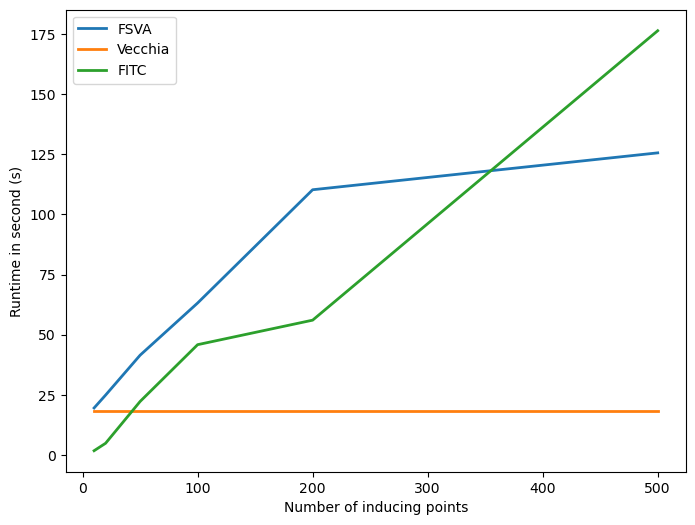

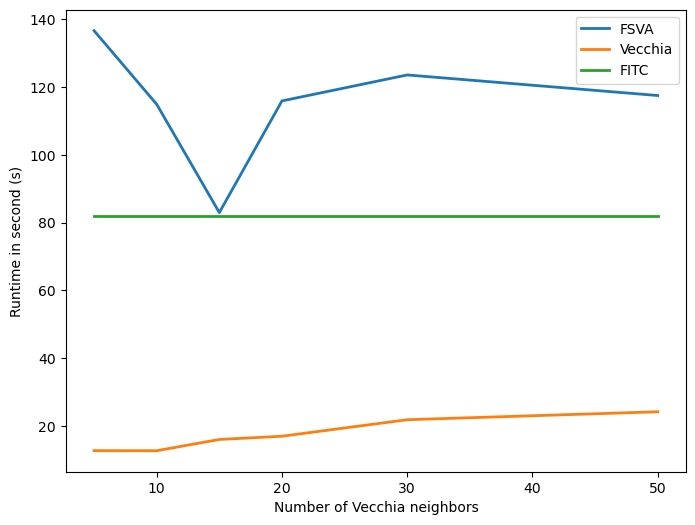

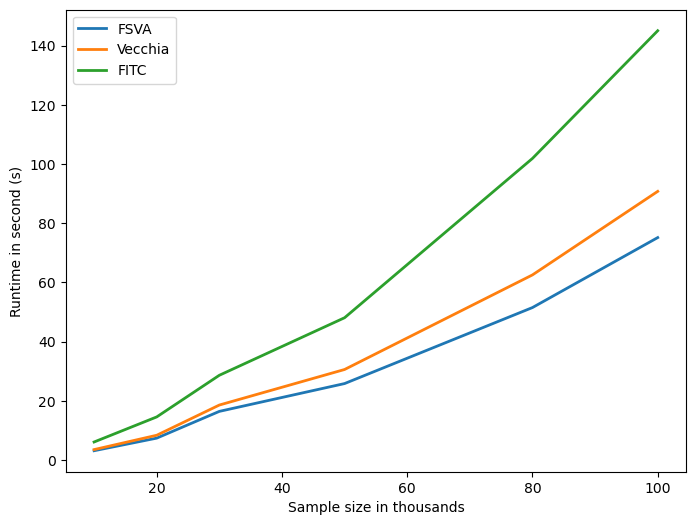

In [8]:
# Plot inducing points
plt.figure(figsize=(8, 6))
plt.plot(vector_ind_points, matrix_t_ip, label='FSVA', linewidth=2)
plt.plot(vector_ind_points, matrix_t_ip_v, label='Vecchia', linewidth=2)
plt.plot(vector_ind_points, matrix_t_ip_f, label='FITC', linewidth=2)

# Add labels and title
plt.xlabel('Number of inducing points')
plt.ylabel('Runtime in second (s)')

# Display the legend
plt.legend()

# Show the plot
plt.show()

# Plot Vecchia neighbors
plt.figure(figsize=(8, 6))
plt.plot(vector_vecchia, matrix_t_vecchia, label='FSVA', linewidth=2)
plt.plot(vector_vecchia, matrix_t_vecchia_v, label='Vecchia', linewidth=2)
plt.plot(vector_vecchia, matrix_t_vecchia_f, label='FITC', linewidth=2)

# Add labels and title
plt.xlabel('Number of Vecchia neighbors')
plt.ylabel('Runtime in second (s)')

# Display the legend
plt.legend()

# Show the plot
plt.show()

# Plot sample size
plt.figure(figsize=(8, 6))
plt.plot(vector_n, matrix_t_n, label='FSVA', linewidth=2)
plt.plot(vector_n, matrix_t_n_v, label='Vecchia', linewidth=2)
plt.plot(vector_n, matrix_t_n_f, label='FITC', linewidth=2)

# Add labels and title
plt.xlabel('Sample size in thousands')
plt.ylabel('Runtime in second (s)')

# Display the legend
plt.legend()

# Show the plot
plt.show()

## Non-Gaussian Data

In [9]:
#X, y, b = simulate_gp_response("bernoulli-logit",100000, 0, 1.0, torch.tensor([(0.25, 0.50,0.75,1.00,1.25)]),1)

In [ ]:
# Convert X and y to a DataFrame
# data = pd.DataFrame(X.numpy(), columns=[f"x{i+1}" for i in range(X.shape[1])])
# data['y'] = y.numpy()
# data['b'] = b.numpy()

# Save to CSV
# data.to_csv("simulated_data_non_Gaussian.csv", index=False)
# print("Data saved to 'simulated_data_non_Gaussian.csv'")

In [12]:
# URL of the raw CSV file on GitHub
url = 'https://raw.githubusercontent.com/TimGyger/FSVA/refs/heads/main/Simulation/simulated_data_non_Gaussian.csv'

# Load the CSV file directly from the URL
df = pd.read_csv(url)

# Select the first 5 columns for X
X = df.iloc[:, :5]  # First 5 columns

# Select the last column for y
y = df.iloc[:, 5]  # Last column

In [13]:
# Convert to numpy:
X_np = X.to_numpy()
y_np = y.to_numpy()

## Experiments

In [ ]:
# Different number of inducing points
vector_ind_points = [10, 20, 50, 100, 200, 500]
# Different number of Vecchia neighbors
vector_vecchia = [5, 10, 15, 20, 30, 50]
# Different number of samples
vector_n = [10, 20, 30, 50, 80, 100]
# Zero matrices
matrix_t_vecchia_p1 = np.zeros((len(vector_vecchia), 1))
matrix_t_ip_p1 = np.zeros((len(vector_ind_points), 1))
matrix_t_n_p1 = np.zeros((len(vector_n), 1))
matrix_t_vecchia_p2 = np.zeros((len(vector_vecchia), 1))
matrix_t_ip_p2 = np.zeros((len(vector_ind_points), 1))
matrix_t_n_p2 = np.zeros((len(vector_n), 1))

matrix_t_vecchia_v = np.zeros((len(vector_vecchia), 1))
matrix_t_ip_v = np.zeros((len(vector_ind_points), 1))
matrix_t_n_v = np.zeros((len(vector_n), 1))
matrix_t_vecchia_f = np.zeros((len(vector_vecchia), 1))
matrix_t_ip_f = np.zeros((len(vector_ind_points), 1))
matrix_t_n_f = np.zeros((len(vector_n), 1))
# Nested loop to iterate over both vectors
for i, val1 in enumerate(vector_ind_points):
    start_time = time.time()
    # FSVecchia with euclidean-based neighbor search
    model_fsva = gpb.GPModel(gp_coords=X_np, cov_function="gaussian_ard", 
                             likelihood="bernoulli_logit",num_neighbors = 30,num_ind_points = val1,ind_points_selection = "kmeans++",
                             matrix_inversion_method = "iterative", gp_approx="vecchia",seed = 2)
    model_fsva.set_optim_params(params={"cg_preconditioner_type": "predictive_process_plus_diagonal",
                                            "piv_chol_rank": 200})
    neg_fsva = model_fsva.neg_log_likelihood(cov_pars = np.array([1.0, 0.25, 0.50,0.75,1.00,1.25]), y = y_np)
    # End the timer
    end_time = time.time()
    matrix_t_ip_p1[i, 0] = end_time - start_time

    start_time = time.time()
    # FSVecchia with euclidean-based neighbor search
    model_fsva = gpb.GPModel(gp_coords=X_np, cov_function="gaussian_ard", 
                             likelihood="bernoulli_logit",num_neighbors = 30,num_ind_points = val1,ind_points_selection = "kmeans++",
                             matrix_inversion_method = "iterative", gp_approx="vecchia",seed = 2)
    model_fsva.set_optim_params(params={"cg_preconditioner_type": "Bt_Sigma_inv_plus_W_B"})
    neg_fsva = model_fsva.neg_log_likelihood(cov_pars = np.array([1.0, 0.25, 0.50,0.75,1.00,1.25]), y = y_np)
    # End the timer
    end_time = time.time()
    matrix_t_ip_p2[i, 0] = end_time - start_time

    # Vecchia
    if i == 0:
        start_time = time.time()
        model_v = gpb.GPModel(gp_coords=X_np, cov_function="gaussian_ard", 
                                 likelihood="bernoulli_logit",num_neighbors = 30,
                                 matrix_inversion_method = "iterative", gp_approx="vecchia",seed = 10)
        neg_v = model_v.neg_log_likelihood(cov_pars = np.array([1.0, 0.25, 0.50,0.75,1.00,1.25]), y = y_np)
        # End the timer
        end_time = time.time()
        matrix_t_ip_v.fill(end_time - start_time)

    # FITC
    start_time = time.time()
    model_fitc = gpb.GPModel(gp_coords=X_np, cov_function="gaussian_ard", 
                             likelihood="bernoulli_logit",num_ind_points = val1,ind_points_selection = "kmeans++",
                             matrix_inversion_method = "cholesky", gp_approx="fitc",seed = 10)
    neg_fitc = model_fitc.neg_log_likelihood(cov_pars = np.array([1.0, 0.25, 0.50,0.75,1.00,1.25]), y = y_np)
    # End the timer
    end_time = time.time()
    matrix_t_ip_f[i, 0] = end_time - start_time
    
for i, val1 in enumerate(vector_vecchia):
    start_time = time.time()
    # FSVecchia with euclidean-based neighbor search
    model_fsva = gpb.GPModel(gp_coords=X_np, cov_function="gaussian_ard", 
                             likelihood="bernoulli_logit",num_neighbors = val1,num_ind_points = 200,ind_points_selection = "kmeans++",
                             matrix_inversion_method = "iterative", gp_approx="vecchia",seed = 2)
    model_fsva.set_optim_params(params={"cg_preconditioner_type": "predictive_process_plus_diagonal",
                                            "piv_chol_rank": 200})
    neg_fsva = model_fsva.neg_log_likelihood(cov_pars = np.array([1.0, 0.25, 0.50,0.75,1.00,1.25]), y = y_np)
    # End the timer
    end_time = time.time()
    matrix_t_vecchia_p1[i, 0] = end_time - start_time

    start_time = time.time()
    # FSVecchia with euclidean-based neighbor search
    model_fsva = gpb.GPModel(gp_coords=X_np, cov_function="gaussian_ard", 
                             likelihood="bernoulli_logit",num_neighbors = val1,num_ind_points = 200,ind_points_selection = "kmeans++",
                             matrix_inversion_method = "iterative", gp_approx="vecchia",seed = 2)
    model_fsva.set_optim_params(params={"cg_preconditioner_type": "Bt_Sigma_inv_plus_W_B"})
    neg_fsva = model_fsva.neg_log_likelihood(cov_pars = np.array([1.0, 0.25, 0.50,0.75,1.00,1.25]), y = y_np)
    # End the timer
    end_time = time.time()
    matrix_t_vecchia_p2[i, 0] = end_time - start_time

    # FITC
    if i == 0:
        start_time = time.time()
        model_fitc = gpb.GPModel(gp_coords=X_np, cov_function="gaussian_ard", 
                                 likelihood="bernoulli_logit",num_ind_points = 200,ind_points_selection = "kmeans++",
                                 matrix_inversion_method = "cholesky", gp_approx="fitc",seed = 10)
        neg_fitc = model_fitc.neg_log_likelihood(cov_pars = np.array([1.0, 0.25, 0.50,0.75,1.00,1.25]), y = y_np)
        # End the timer
        end_time = time.time()
        matrix_t_vecchia_f.fill(end_time - start_time)

    # Vecchia
    start_time = time.time()
    model_v = gpb.GPModel(gp_coords=X_np, cov_function="gaussian_ard", 
                          likelihood="bernoulli_logit",num_neighbors = val1,
                          matrix_inversion_method = "iterative", gp_approx="vecchia",seed = 10)
    neg_v = model_v.neg_log_likelihood(cov_pars = np.array([1.0, 0.25, 0.50,0.75,1.00,1.25]), y = y_np)
    # End the timer
    end_time = time.time()
    matrix_t_vecchia_v[i, 0] = end_time - start_time

for i, val1 in enumerate(vector_n):
    if val1 < 100:
        np.random.seed(1)
        indices = np.random.choice(X_np.shape[0], size=val1*1000, replace=False)
        # Select the downsampled data
        X_np_sampled = X_np[indices]
        y_np_sampled = y_np[indices]
    else:
        X_np_sampled = X_np
        y_np_sampled = y_np
    
    start_time = time.time()
    # FSVecchia with euclidean-based neighbor search
    model_fsva = gpb.GPModel(gp_coords=X_np_sampled, cov_function="gaussian_ard", 
                             likelihood="bernoulli_logit",num_neighbors = 30,num_ind_points = 200,ind_points_selection = "kmeans++",
                             matrix_inversion_method = "iterative", gp_approx="vecchia",seed = 2)
    model_fsva.set_optim_params(params={"cg_preconditioner_type": "predictive_process_plus_diagonal",
                                            "piv_chol_rank": 200})
    neg_fsva = model_fsva.neg_log_likelihood(cov_pars = np.array([1.0, 0.25, 0.50,0.75,1.00,1.25]), y = y_np_sampled)
    # End the timer
    end_time = time.time()
    matrix_t_n_p1[i, 0] = end_time - start_time

    start_time = time.time()
    # FSVecchia with euclidean-based neighbor search
    model_fsva = gpb.GPModel(gp_coords=X_np_sampled, cov_function="gaussian_ard", 
                             likelihood="bernoulli_logit",num_neighbors = 30,num_ind_points = 200,ind_points_selection = "kmeans++",
                             matrix_inversion_method = "iterative", gp_approx="vecchia",seed = 2)
    model_fsva.set_optim_params(params={"cg_preconditioner_type": "Bt_Sigma_inv_plus_W_B"})
    neg_fsva = model_fsva.neg_log_likelihood(cov_pars = np.array([1.0, 0.25, 0.50,0.75,1.00,1.25]), y = y_np_sampled)
    # End the timer
    end_time = time.time()
    matrix_t_n_p2[i, 0] = end_time - start_time

    # Vecchia
    model_vecchia = gpb.GPModel(gp_coords=X_np_sampled, cov_function="gaussian_ard", 
                             likelihood="bernoulli_logit",num_neighbors = 30,
                             matrix_inversion_method = "iterative", gp_approx="vecchia",seed = 10)
    neg_vecchia = model_vecchia.neg_log_likelihood(cov_pars = np.array([1.0, 0.25, 0.50,0.75,1.00,1.25]), y = y_np_sampled)
    # End the timer
    end_time = time.time()
    matrix_t_n_v[i, 0] = end_time - start_time

    # FITC
    model_fitc = gpb.GPModel(gp_coords=X_np_sampled, cov_function="gaussian_ard", 
                             likelihood="bernoulli_logit",num_ind_points = 200,ind_points_selection = "kmeans++",
                             matrix_inversion_method = "cholesky", gp_approx="fitc",seed = 10)
    neg_fitc = model_fitc.neg_log_likelihood(cov_pars = np.array([1.0, 0.25, 0.50,0.75,1.00,1.25]), y = y_np_sampled)
    # End the timer
    end_time = time.time()
    matrix_t_n_f[i, 0] = end_time - start_time

    

[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] FindModePostRandEffCalcMLLFSAVecchia: finished after 3 iterations 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 


### Plots

In [ ]:
# Plot inducing points
plt.figure(figsize=(8, 6))
plt.plot(vector_ind_points, matrix_t_ip_p1, label='FSVA with FITC', linewidth=2)
plt.plot(vector_ind_points, matrix_t_ip_p2, label='FSVA with FSVADU', linewidth=2)
plt.plot(vector_ind_points, matrix_t_ip_v, label='Vecchia', linewidth=2)
plt.plot(vector_ind_points, matrix_t_ip_f, label='FITC', linewidth=2)

# Add labels and title
plt.xlabel('Number of inducing points')
plt.ylabel('Runtime in second (s)')

# Display the legend
plt.legend()

# Show the plot
plt.show()

# Plot Vecchia neighbors
plt.figure(figsize=(8, 6))
plt.plot(vector_vecchia, matrix_t_vecchia_p1, label='FSVA with FITC', linewidth=2)
plt.plot(vector_vecchia, matrix_t_vecchia_p2, label='FSVA with FSVADU', linewidth=2)
plt.plot(vector_vecchia, matrix_t_vecchia_v, label='Vecchia', linewidth=2)
plt.plot(vector_vecchia, matrix_t_vecchia_f, label='FITC', linewidth=2)

# Add labels and title
plt.xlabel('Number of Vecchia neighbors')
plt.ylabel('Runtime in second (s)')

# Display the legend
plt.legend()

# Show the plot
plt.show()

# Plot sample size
plt.figure(figsize=(8, 6))
plt.plot(vector_n, matrix_t_n_p1, label='FSVA with FITC', linewidth=2)
plt.plot(vector_n, matrix_t_n_p2, label='FSVA with FSVADU', linewidth=2)
plt.plot(vector_n, matrix_t_n_v, label='Vecchia', linewidth=2)
plt.plot(vector_n, matrix_t_n_f, label='FITC', linewidth=2)

# Add labels and title
plt.xlabel('Sample size in thousands')
plt.ylabel('Runtime in second (s)')

# Display the legend
plt.legend()

# Show the plot
plt.show()